In [3]:
import numpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import os
import sys

In [4]:
def get_data_paths_from_binary(path_to_data,variable,delim='.',file_end='1'):
    '''This function returns a list of file names and paths with filenames to the files that you want given the path to the data and the varible directory. Returns sorted
        e.g.
        path_to_data = './home/user/data/' 
        varible = 'var1'
        get_data_path_from_binary(path_to_data,variable,delim='.',file_end='1')
        where delim,file_end selects for what file ending will be chosen
        returns
        ['d.a.t.a1.1','d.a.t.a2.1','d.a.t.a3.1'],['./home/user/data/var1/d.a.t.a1.1',''./home/user/data/var1/d.a.t.a2.1'',''./home/user/data/var1/d.a.t.a3.1'']
        '''
    all_paths = []
    filename_ = []
    for filename in os.listdir(path_to_data + variable):
        f = os.path.join(path_to_data,variable, filename)
    # checking if it is a file
        if filename.split(delim)[-1]==file_end:
            all_paths.append(filename)
            filename_.append(f)
    return sorted(all_paths), sorted(filename_)

def convert_itter_to_datetime(number,datetime_start,timestep,shift_itter=0):
    '''converts an itteration number to a datetime'''
    itter_dt = datetime.fromtimestamp(datetime_start.timestamp()+(int(number)+int(shift_itter))*timestep)
    return itter_dt

def read_ecco_field_to_faces(file_path, llc, dim):

    Nr = 50

    grid_array = np.fromfile(file_path,'>f4')
    N = 13*llc*llc

    field_faces = {}

    if dim == 2:
        points_counted = 0
        for i in range(1, 6):
            if i < 3:
                n_points = 3 * llc * llc
                grid = grid_array[points_counted:points_counted + n_points]
                grid = np.reshape(grid, (3 * llc, llc))
            if i == 3:
                n_points = llc * llc
                grid = grid_array[points_counted:points_counted + n_points]
                grid = np.reshape(grid, (llc, llc))
            if i > 3:
                n_points = 3 * llc * llc
                grid = grid_array[points_counted:points_counted + n_points]
                grid = np.reshape(grid, (llc, 3 * llc))
            field_faces[i] = grid
            points_counted += n_points

    if dim==3:

        for i in range(1, 6):
            if i < 3:
                face_grid = np.zeros((Nr, 3 * llc, llc))
            elif i == 3:
                face_grid = np.zeros((Nr, llc, llc))
            if i > 3:
                face_grid = np.zeros((Nr, llc, 3 * llc))
            field_faces[i]=face_grid

        for nr in range(Nr):
            points_counted = 0
            level_grid = grid_array[nr * N:(nr + 1) * N]
            for i in range(1,6):
                if i < 3:
                    n_points = 3*llc*llc
                    grid = level_grid[points_counted:points_counted+n_points]
                    grid = np.reshape(grid,(3*llc,llc))
                if i == 3:
                    n_points = llc * llc
                    grid = level_grid[points_counted:points_counted + n_points]
                    grid = np.reshape(grid, (llc, llc))
                if i > 3:
                    n_points = 3 * llc * llc
                    grid = level_grid[points_counted:points_counted + n_points]
                    grid = np.reshape(grid, (llc, 3*llc))
                field_faces[i][nr,:,:] = grid

                points_counted += n_points

        # plt.imshow(grid,origin='lower')
        # plt.show()

    return(field_faces)


def convert_binary_to_nc(file_name,file_path, shape, dims_list, coords_list, name,llc_faces_rotation=False,llc=270,time_in_name_location=None, output_filepath='./my_netcdf.nc',to_nc_mode='w'):
    '''converts binary files to netcdf through xarray framework
    '''
    if llc_faces_rotation==False:
        file = np.fromfile(file_path,'>f4')
        file = np.reshape(file, shape)
        if time_in_name_location!=None:
            time = [int(filename[time_in_name_location[0]:time_in_name_location[1]])]
        field = xr.DataArray(file,coords=coords_list,dims=dims_list).rename(name)
        field.to_netcdf(output_filepath,mode=to_nc_mode)
        field.close()
    elif llc_faces_rotation==True:
        #faces = read_ecco_field_to_faces(file_path,llc,len(shape)-1)
        #faces = np.reshape(np.rot90(read_ecco_field_to_faces(file_path,llc,len(shape)-1),(3,llc,llc))

        if len(shape)-1==2:
            face1 = np.reshape(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[1],(3,llc,llc))
            face2 = np.reshape(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[2],(3,llc,llc))
            face3 = np.reshape(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[3],(1,llc,llc))
            face4 = np.reshape(np.rot90(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[4]),(3,llc,llc))
            face5 = np.reshape(np.rot90(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[5]),(3,llc,llc))
                           
            tile_0 = np.reshape(face1[0],(1,llc,llc))
            tile_1 = np.reshape(face1[1],(1,llc,llc))
            tile_2 = np.reshape(face1[2],(1,llc,llc))
            tile_3 = np.reshape(face2[0],(1,llc,llc))
            tile_4 = np.reshape(face2[1],(1,llc,llc))
            tile_5 = np.reshape(face2[2],(1,llc,llc))
            tile_6 = np.reshape(face3[0],(1,llc,llc))
            tile_7 = np.reshape(face4[0],(1,llc,llc))
            tile_8 = np.reshape(face4[1],(1,llc,llc))
            tile_9 = np.reshape(face4[2],(1,llc,llc))
            tile_10 = np.reshape(face5[2][::-1,:],(1,llc,llc))
            tile_11 = np.reshape(face5[1],(1,llc,llc))
            tile_12 = np.reshape(face5[0],(1,llc,llc))
            file = np.concatenate([tile_0,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,tile_10,tile_11,tile_12])
            print(np.shape(file))
            field = xr.DataArray(file,coords=coords_list,dims=dims_list).rename(name)
            field.to_netcdf(output_filepath,mode=to_nc_mode)
            field.close()
        elif len(shape)-1==3:
            Nr = 50
            face1 = np.reshape(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[1],(3,Nr,llc,llc))
            face2 = np.reshape(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[2],(3,Nr,llc,llc))
            face3 = np.reshape(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[3],(1,Nr,llc,llc))
            face4 = np.reshape(np.rot90(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[4]),(3,Nr,llc,llc))
            face5 = np.reshape(np.rot90(read_ecco_field_to_faces(file_path,llc,len(shape)-1)[5]),(3,Nr,llc,llc))
                           
            tile_0 = np.reshape(face1[0],(1,Nr,llc,llc))
            tile_1 = np.reshape(face1[1],(1,Nr,llc,llc))
            tile_2 = np.reshape(face1[2],(1,Nr,llc,llc))
            tile_3 = np.reshape(face2[0],(1,Nr,llc,llc))
            tile_4 = np.reshape(face2[1],(1,Nr,llc,llc))
            tile_5 = np.reshape(face2[2],(1,Nr,llc,llc))
            tile_6 = np.reshape(face3[0],(1,Nr,llc,llc))
            tile_7 = np.reshape(face4[0],(1,Nr,llc,llc))
            tile_8 = np.reshape(face4[1],(1,Nr,llc,llc))
            tile_9 = np.reshape(face4[2],(1,Nr,llc,llc))
            tile_10 = np.reshape(face5[0],(1,Nr,llc,llc))
            tile_11 = np.reshape(face5[1],(1,Nr,llc,llc))
            tile_12 = np.reshape(face5[2],(1,Nr,llc,llc))
            file = np.concatenate([tile_0,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,tile_10,tile_11,tile_12])
            print(np.shape(file))
            field = xr.DataArray(file,coords=coords_list,dims=dims_list).rename(name)
            field.to_netcdf(output_filepath,mode=to_nc_mode)
            field.close()

In [5]:
def convert_mitgcm_grid_to_nc(path_to_grid_files,dim_of_grid,output_path='./grid.nc'):
    grid_prefix_2d = ['Depth','RAZ','YC','DXC','DYC','XC','YG','DXG','DYG','RAC','XG','RC']
    grid_prefix_3d = ['hFacC']
    if len(dim_of_grid)<4:
        if type(dim_of_grid)==tuple:
            dimx, dimy = dim_of_grid[0], dim_of_grid[1]
            try:
                dimz = dim_of_grid[2]
            except:
                print('no 3d shape')
        elif type(dim_of_grid)==str:
            dimx, dimy = dim_of_grid.split('_')[1].split('x')
            try:
                dimz = dim_of_grid[2]
            except:
    
                print('no 3d shape')
    #2D files
        for i in range(0,len(grid_prefix_2d)):
        
            file1 = path_to_grid_files+'/'+grid_prefix_2d[i]+'_'+str(dimx)+'x'+str(dimy)
            file_name1 = grid_prefix_2d[i]+'_'+str(dimx)+'x'+str(dimy)
            shape = (dimy,dimx) 
            i0 = np.arange(dimx)
            j0 = np.arange(dimy)
            dim = ['i','j']
            coord = [j0,i0]
            convert_binary_to_nc(file_name1,file1,shape,dim,coord,grid_prefix_2d[i],output_filepath= './.'+file_name1+'_'+str(dimx)+'x'+str(dimy)+'.nc')
    
    #3D files
        try:
            k0 = np.arange(dimz)
            dim = ['i','j','k']
            coords = [j0,i0,k0]
        
            for j in range(0,len(grid_prefix_3d)):
                file2 = path_to_grid_files+'/'+grid_prefix_3d[j]+'_'+str(dimx)+'x'+str(dimy)+'x'+str(dimz)
                file_name2 = grid_prefix_3d[j]+'_'+str(dimx)+'x'+str(dimy)+'x'+str(dimz)
                shape = (dimy,dimx,dimz)
                convert_binary_to_nc(file_name2,file2,shape,dim,coords,grid_prefix_3d[j],output_filepath= './.'+file_name2+'.nc')
        except:
            print('no 3d shape')
    elif len(dim_of_grid)==4:
        if type(dim_of_grid)==tuple:
            dimx, dimy = dim_of_grid[1], dim_of_grid[2]
            try:
                dimz = dim_of_grid[3]
            except:
                print('no 3d shape')
        # elif type(dim_of_grid)==str:
        #     dimx, dimy = dim_of_grid.split('_')[1].split('x')
        #     try:
        #         dimz = dim_of_grid[2]
        #     except:
    
        #         print('no 3d shape')
    #2D files
        for i in range(0,len(grid_prefix_2d)):
            
            file1 = path_to_grid_files+'/'+grid_prefix_2d[i]+'.data'
            file_name1 = grid_prefix_2d[i]+'.data'
            tile_shape = dim_of_grid[0]
            shape = (tile_shape,dimy,dimx)
            tile = np.arange(tile_shape)
            i0 = np.arange(dimx)
            j0 = np.arange(dimy)
            dim = ['tile','i','j']
            coord = [tile,i0,j0]
            convert_binary_to_nc(file_name1,file1,shape,dim,coord,grid_prefix_2d[i],llc_faces_rotation=True,output_filepath= './.'+file_name1+'_'+str(dimx)+'x'+str(dimy)+'.nc')
    
    #3D files
        try:
            k0 = np.arange(dimz)
            dim = ['tile','k','i','j']
            coords = [tile,k0,j0,i0]
        
            for j in range(0,len(grid_prefix_3d)):
                file2 = path_to_grid_files+'/'+grid_prefix_3d[j]+'.data'
                file_name2 = grid_prefix_3d[j]+'.data'
                shape = (tile_shape,dimz,dimy,dimx)
                convert_binary_to_nc(file_name2,file2,shape,dim,coords,grid_prefix_3d[j],llc_faces_rotation=True,output_filepath= './.'+file_name2+'_'+str(dimx)+'x'+str(dimy)+'x'+str(dimz)+'.nc')
        except:
            print('no 3d shape')
    two_d_files, two_d_filepaths= get_data_paths_from_binary('./','./',delim='_',file_end=str(dimx)+'x'+str(dimy)+'.nc')
    three_d_files, three_d_filepaths = get_data_paths_from_binary('./','./',delim='_',file_end=str(dimx)+'x'+str(dimy)+'x'+str(dimz)+'.nc')
    total_file_paths = two_d_filepaths+three_d_filepaths
    grid_full = xr.open_mfdataset(total_file_paths)
    grid_full.to_netcdf(output_path)
    grid_full.close()
    for files in total_file_paths:
        os.system('rm '+ files)

In [35]:
i=0
grid_prefix_2d = ['Depth','RAZ','YC','DXC','DYC','XC','YG','DXG','DYG','RAC','XG']
file1 = grid_path+'/'+grid_prefix_2d[i]+'.data'
file_name1 = grid_prefix_2d[i]+'.data'
tile_shape = 13
dimx=270
dimy=270
shape = (tile_shape,dimy,dimx)
tile = np.arange(tile_shape)
i0 = np.arange(dimx)
j0 = np.arange(dimy)
dim = ['tile','j','i']
coord = [tile,i0,j0]
convert_binary_to_nc(file_name1,file1,shape,dim,coord,grid_prefix_2d[i],faces_rotation=True,output_filepath= './.'+file_name1+'_'+str(dimx)+'x'+str(dimy)+'.nc')

(13, 270, 270)


In [8]:
dimx=270
dimy=270
dimz=50

two_d_files, two_d_filepaths= get_data_paths_from_binary('./','./',delim='_',file_end=str(dimx)+'x'+str(dimy)+'.nc')
three_d_files, three_d_filepaths = get_data_paths_from_binary('./','./',delim='_',file_end=str(dimx)+'x'+str(dimy)+'x'+str(dimz)+'.nc')
total_file_paths = two_d_filepaths+three_d_filepaths

for files in total_file_paths:
    os.system('rm '+ files)



In [6]:
path_tohd = '/media/basil/Elements/data/llc270/'
grid_path = path_tohd + 'grid'
grid_files, grid_filepaths =get_data_paths_from_binary(path_tohd,'grid',file_end='data')

In [7]:
convert_mitgcm_grid_to_nc(grid_path,(13,270,270,50),output_path='./llc270_grid_test.nc')

(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)
(13, 270, 270)


ValueError: cannot reshape array of size 50 into shape (810,270)

In [16]:
file = np.fromfile(grid_filepaths[-1],'>f4')

In [17]:
len(file)/13/270/270
shape = (270,270,50)

50.0

In [51]:
grid = xr.open_dataset('./llc270_grid_test.nc')
#grid.close()

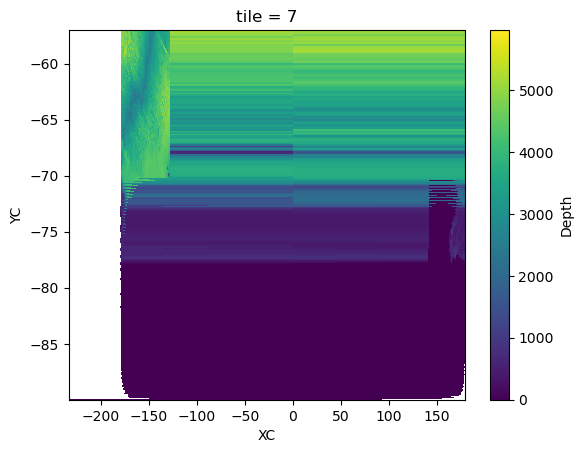

In [103]:
grid_latlon = grid.set_coords({'XC','YC'})#['Depth'].plot(x='XC',y='YC')
grid_latlon.isel(tile=7)['Depth'].plot(x='XC',y='YC')

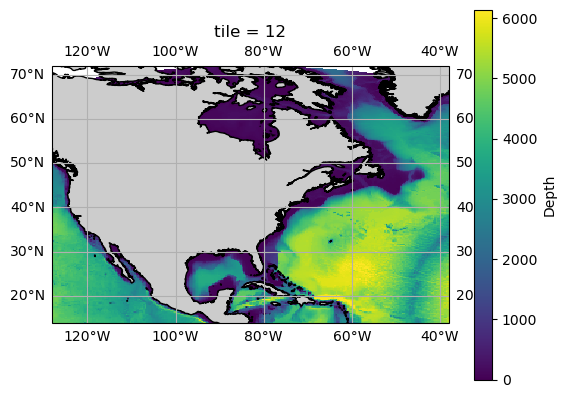

In [115]:
#plt.gca().invert_yaxis()
#plt.gca().invert_yaxis()

proj = ccrs.PlateCarree()

ax = plt.axes(projection=proj)

grid_latlon['Depth'].isel(tile=12).plot(x = 'XC',y='YC', transform=ccrs.PlateCarree())
#grid_latlon['Depth'].isel(tile=10).plot(x = 'XC',y='YC', transform=ccrs.PlateCarree())

#new_third_green['SALT'].plot(vmin=32,vmax=34.5, cmap='cmo.haline')
coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")

ax.add_feature(coast_10m)
gl = ax.gridlines(draw_labels=True)
plt.savefig('./bad_grid.png')

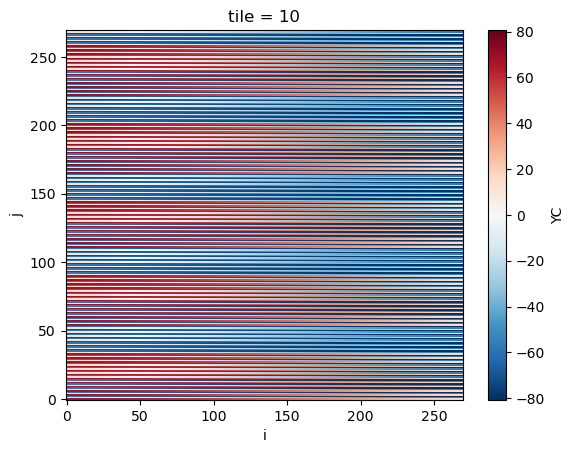

In [230]:
grid_latlon.isel(tile=10)['YC']
plt.savefig('./bad_grid.png')

In [231]:
def read_ecco_field_to_faces(file_path, llc, dim):

    Nr = 50

    grid_array = np.fromfile(file_path,'>f4')
    N = 13*llc*llc

    field_faces = {}

    if dim == 2:
        points_counted = 0
        for i in range(1, 6):
            if i < 3:
                n_points = 3 * llc * llc
                grid = grid_array[points_counted:points_counted + n_points]
                grid = np.reshape(grid, (3 * llc, llc))
            if i == 3:
                n_points = llc * llc
                grid = grid_array[points_counted:points_counted + n_points]
                grid = np.reshape(grid, (llc, llc))
            if i > 3:
                n_points = 3 * llc * llc
                grid = grid_array[points_counted:points_counted + n_points]
                grid = np.reshape(grid, (llc, 3 * llc))
            field_faces[i] = grid
            points_counted += n_points

    if dim==3:

        for i in range(1, 6):
            if i < 3:
                face_grid = np.zeros((Nr, 3 * llc, llc))
            elif i == 3:
                face_grid = np.zeros((Nr, llc, llc))
            if i > 3:
                face_grid = np.zeros((Nr, llc, 3 * llc))
            field_faces[i]=face_grid

        for nr in range(Nr):
            points_counted = 0
            level_grid = grid_array[nr * N:(nr + 1) * N]
            for i in range(1,6):
                if i < 3:
                    n_points = 3*llc*llc
                    grid = level_grid[points_counted:points_counted+n_points]
                    grid = np.reshape(grid,(3*llc,llc))
                if i == 3:
                    n_points = llc * llc
                    grid = level_grid[points_counted:points_counted + n_points]
                    grid = np.reshape(grid, (llc, llc))
                if i > 3:
                    n_points = 3 * llc * llc
                    grid = level_grid[points_counted:points_counted + n_points]
                    grid = np.reshape(grid, (llc, 3*llc))
                field_faces[i][nr,:,:] = grid

                points_counted += n_points

        # plt.imshow(grid,origin='lower')
        # plt.show()

    return(field_faces)

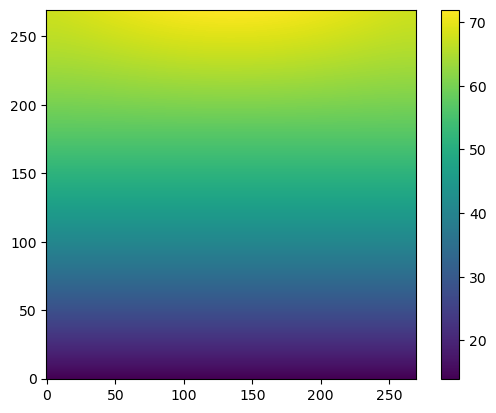

In [258]:
grid_files, grid_filepaths =get_data_paths_from_binary(path_tohd,'grid',file_end='data')
faces = np.reshape(np.rot90(read_ecco_field_to_faces(grid_filepaths[-3],270,2)[5]),(3,270,270))
plt.imshow(faces[2])
plt.gca().invert_yaxis()
plt.colorbar()

In [233]:
grid_filepaths[-3]
grid_filepaths[-5]

['DXC.data',
 'DXG.data',
 'DYC.data',
 'DYG.data',
 'Depth.data',
 'RAC.data',
 'RAZ.data',
 'XC.data',
 'XG.data',
 'YC.data',
 'YG.data',
 'hFacC.data']

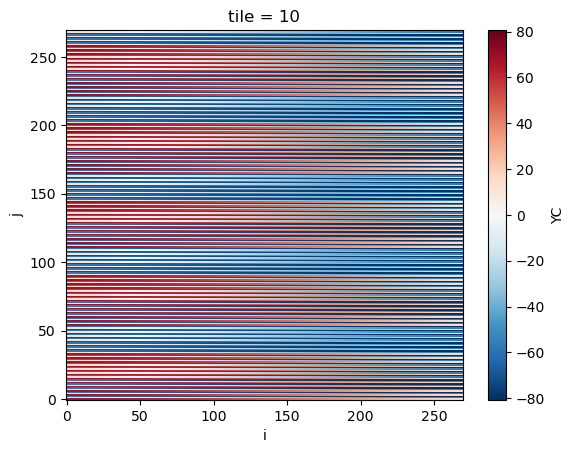

In [255]:
grid_latlon.isel(tile=10)['YC'] = (['i','j'],faces[1])
